In [1]:
from datetime import timedelta

import implicit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix, coo_matrix

from utils import train_test_split

In [2]:
df = pd.read_csv("./transactions_train.csv")
articles = pd.read_csv("./articles.csv")

df.t_dat = pd.to_datetime(df.t_dat)

### 최근 3개월로 한정

In [3]:
print(f"기존 데이터 수: {len(df):,}")
last_90_days = df.t_dat.max() - timedelta(days=90)
df = df[df.t_dat >= last_90_days]
print(f"최근 3개월 데이터 수: {len(df):,}")

기존 데이터 수: 31,788,324
최근 3개월 데이터 수: 3,904,391


In [4]:
train_df, test_df = train_test_split(df)

train: 2020-06-24 ~ 2020-09-14
test: 2020-09-15 ~ 2020-09-22


### Preprocess

In [5]:
ALL_USERS = df['customer_id'].unique().tolist()
ALL_ITEMS = df['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

train_df['user_id'] = train_df['customer_id'].map(user_map)
train_df['item_id'] = train_df['article_id'].map(item_map)

<ipython-input-5-84eaa67298d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_id'] = train_df['customer_id'].map(user_map)
<ipython-input-5-84eaa67298d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_id'] = train_df['article_id'].map(item_map)


In [6]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

def train(coo_train, factors=200, iterations=15, regularization=0.01, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model

In [7]:
coo_train = to_user_item_coo(train_df)
csr_train = coo_train.tocsr()

In [8]:
best_params = {'factors': 500, 'iterations': 3, 'regularization': 0.01}
model = train(coo_train, **best_params)

/Users/kakao/opt/anaconda3/lib/python3.8/site-packages/implicit/utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


In [9]:
preds = []
batch_size = 2000
to_generate = np.arange(len(ALL_USERS))
for startidx in tqdm(range(0, len(to_generate), batch_size)):
    batch = to_generate[startidx : startidx + batch_size]
    ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
    for i, userid in enumerate(batch):
        customer_id = user_ids[userid]
        user_items = ids[i]
        article_ids = [item_ids[item_id] for item_id in user_items]
        preds.append((customer_id, ' '.join([str(i) for i in article_ids])))

df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])

100%|██████████| 263/263 [03:04<00:00,  1.43it/s]


In [10]:
df_preds = df_preds.set_index("customer_id")

In [11]:
df_preds

,prediction
customer_id,
0001b0127d3e5ff8dadcfc6e5043682dba2070f2667081623faeb31c996242a6,791587001 559630029 844409002 739590038 834217...
000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9,733749001 816588001 556255001 733749010 556260...
000934651054f08396856cd83fad3b36b97ab95a0baf79cf86769e92bf3fef40,610776002 863595006 845790006 845790001 842112...
000c742a054f1180117024953ea31c3fa65eb47e69990a405f4fc5a2d3fbe6aa,610776001 685816001 816423002 859105006 865076...
000da6daeb90ef9a70238bf9b1aa54c7ce40a5e0fcf2207011806ee379bd089b,882760001 882760003 882760005 850984001 850984...
...,...
ff5b8a8b26bf93a66290e9bd1b73393ac6a58968a7851941508cce49f5dfa469,699923113 842112001 842112005 681381003 834368...
ff6f55a51af284b71dcd264396b299e548f968c1769e71148763bd4fce26b40d,699923113 842112001 842112005 681381003 834368...
ff732b98019465f078144bae647d7d9765d76e3431ef926a7c5064783f7027a6,699923113 842112001 842112005 681381003 834368...


In [12]:
res = []
for customer_id, group in tqdm(test_df.groupby("customer_id")):

    pred = set([int(i) for i in df_preds.loc[customer_id].prediction.split()])
    truth = set(group.article_id)
    catched = pred & truth
    
    res.append([len(truth), len(catched)])

100%|██████████| 75481/75481 [00:08<00:00, 9423.64it/s]


In [13]:
eval_df = pd.DataFrame(res, columns=["total", "catch"])

In [14]:
eval_df.catch.sum() / eval_df.total.sum()

0.020796882791963553

In [15]:
res = []
for total_count, group in eval_df.groupby("total"):
    res.append([total_count, group.catch.sum(), group.total.sum()])

eval_by_total = pd.DataFrame(res, columns=["total_count", "catch_sum", "total_sum"])
eval_by_total = eval_by_total.assign(catch_ratio = eval_by_total.catch_sum / eval_by_total.total_sum)

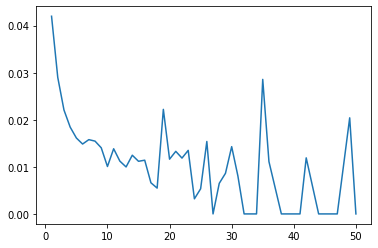

In [16]:
plt.plot(eval_by_total.total_count, eval_by_total.catch_ratio)

### 제출용

In [24]:
ALL_USERS = df['customer_id'].unique().tolist()
ALL_ITEMS = df['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

In [27]:
df['user_id'] = df['customer_id'].map(user_map)
df['item_id'] = df['article_id'].map(item_map)

In [28]:
coo_train = to_user_item_coo(df)
csr_train = coo_train.tocsr()

In [29]:
best_params = {'factors': 500, 'iterations': 3, 'regularization': 0.01}
model = train(coo_train, **best_params)

In [53]:
preds = []
batch_size = 2000
to_generate = np.arange(len(ALL_USERS))
for startidx in tqdm(range(0, len(to_generate), batch_size)):
    batch = to_generate[startidx : startidx + batch_size]
    ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
    for i, userid in enumerate(batch):
        customer_id = user_ids[userid]
        user_items = ids[i]
        article_ids = [item_ids[item_id] for item_id in user_items]
        preds.append((customer_id, ' '.join([str(i).zfill(10) for i in article_ids])))
df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])

100%|██████████| 263/263 [03:09<00:00,  1.39it/s]


In [54]:
popular_1day_by_age = pd.read_csv("submissions/popular_1day_by_age.csv")

In [55]:
df_preds = df_preds.rename(columns={"prediction":"prediction_als"})

In [56]:
popular_1day_by_age = popular_1day_by_age.merge(df_preds, on="customer_id", how="left")

In [59]:
popular_1day_by_age.prediction_als = popular_1day_by_age.prediction_als.fillna(popular_1day_by_age.prediction)

In [60]:
popular_1day_by_age.prediction = popular_1day_by_age.prediction_als

In [62]:
popular_1day_by_age = popular_1day_by_age.drop("prediction_als", axis=1)

In [64]:
popular_1day_by_age.to_csv("./submissions/als.csv", index=False)

### 최근 1주일간 판매가 있었던 것을 상위로

In [ ]:
preds = []
batch_size = 2000
to_generate = np.arange(len(ALL_USERS))
for startidx in tqdm(range(0, len(to_generate), batch_size)):
    batch = to_generate[startidx : startidx + batch_size]
    ids, scores = model.recommend(batch, csr_train[batch], N=50, filter_already_liked_items=False)
    for i, userid in enumerate(batch):
        customer_id = user_ids[userid]
        user_items = ids[i]
        article_ids = [item_ids[item_id] for item_id in user_items]
        preds.append((customer_id, ' '.join([str(i) for i in article_ids])))

df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])